<a href="https://colab.research.google.com/github/DariiaKhoroshchuk/deep_learning_labs/blob/master/Lab6_Dariia_Khoroshchuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, RNN, GRU, Bidirectional, ConvLSTM2D, Flatten
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils import pad_sequences
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics


import math
import sklearn
import sklearn.preprocessing
import datetime
import os

import tensorflow as tf
%matplotlib inline

# Case 1. Sinus wave proof of concept

**Sinus & Cosinus Waves**

In [ ]:
def gen_signal(SIN=False, COS=False):
    time = np.arange(0, 3, 0.001)
    frequency = 10
    signal =  np.multiply(np.sin(2 * np.pi * frequency * time),SIN) + np.multiply(np.cos(2 * np.pi * frequency * time),COS)
    return signal

In [ ]:
# df = pd.DataFrame(data = gen_signal(SIN=True), columns = ["sin"])

In [ ]:
df = pd.DataFrame(data = {"sin": gen_signal(SIN=True), "cos": gen_signal(COS=True), "sin&cos": gen_signal(SIN=True, COS=True)})

In [ ]:
df.head()

,sin,cos,sin&cos
0,0.000000,1.000000,1.000000
1,0.062791,0.998027,1.060817
2,0.125333,0.992115,1.117448
3,0.187381,0.982287,1.169669
4,0.248690,0.968583,1.217273


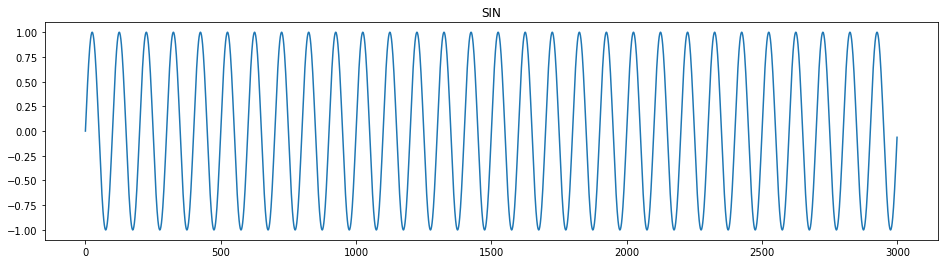

In [ ]:
df["sin"][:].plot(figsize=(16,4),legend=False, title="SIN")

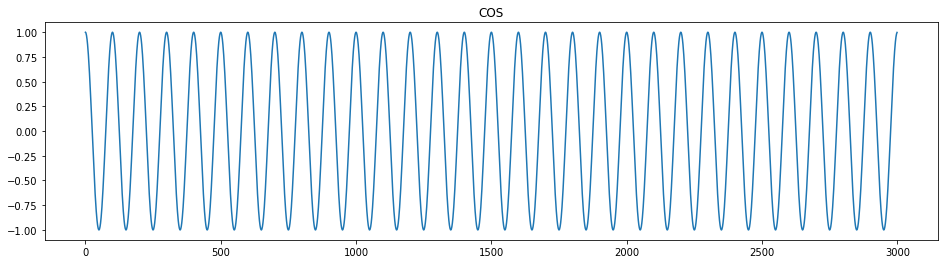

In [ ]:
df["cos"][:].plot(figsize=(16,4),legend=False, title="COS")

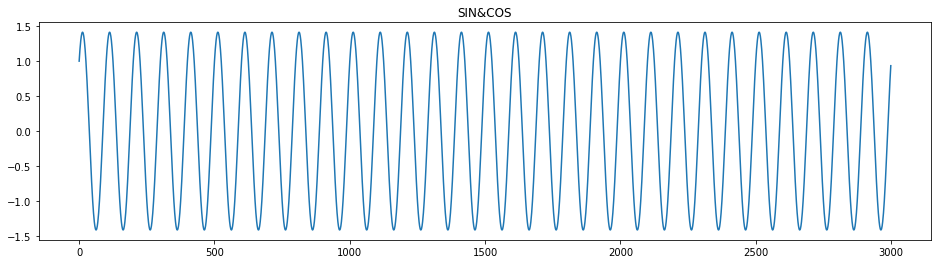

In [ ]:
df["sin&cos"][:].plot(figsize=(16,4),legend=False, title="SIN&COS")

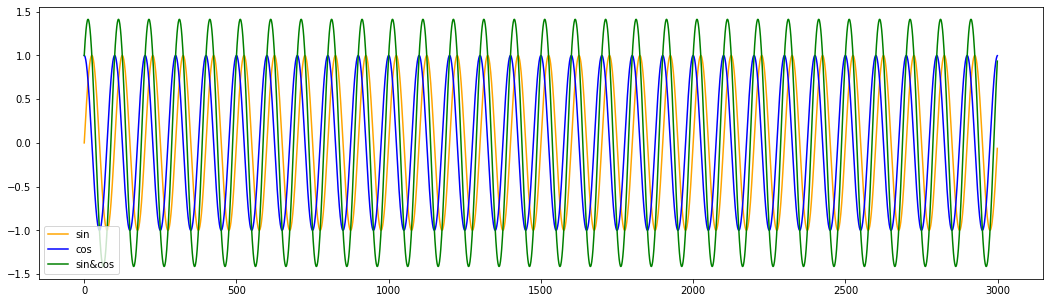

In [ ]:
fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(df["sin"][:], color = 'orange', label='sin')
ax.plot(df["cos"][:], color = 'blue', label='cos')
ax.plot(df["sin&cos"][:], 'g', label='sin&cos')
ax.legend();  # Add a legend.

**Load data**

In [ ]:
def load_data(dataset, column, seq_len):
    # A support function to help prepare datasets for an RNN/LSTM/GRU
    data = dataset.loc[:,column]
    sequence_length = seq_len + 1
    result = []
    
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)

    #Last 10% is used for validation test, first 90% for training
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

In [ ]:
enrol_window = 100
feature_train, label_train, feature_test, label_test = load_data(df, 'sin', enrol_window)
print ('enrol window set to', enrol_window )
print ('Datasets generated')

enrol window set to 100
Datasets generated


In [ ]:
print(feature_train[0][0], label_train[0])
print(feature_train.shape)

[0.68454711] 0.6845471059286884
(2609, 100, 1)


In [ ]:
enrol_window = 100
feature_train_c, label_train_c, feature_test_c, label_test_c = load_data(df, 'cos', enrol_window)
print ('enrol window set to', enrol_window )
print ('Datasets generated')

enrol window set to 100
Datasets generated


In [ ]:
enrol_window = 100
feature_train_sc, label_train_sc, feature_test_sc, label_test_sc = load_data(df, 'sin&cos', enrol_window)
print ('enrol window set to', enrol_window )
print ('Datasets generated')

enrol window set to 100
Datasets generated


**Inintial Model**

In [ ]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:],verbose = 0)[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show() 

In [ ]:
def train_test_model(model, feature_train, label_train, feature_test, label_test):
  #Train the model
  model1 = model(feature_train)
  model1.fit(feature_train, label_train, batch_size=512, epochs=20, validation_data = (feature_test, label_test))

  #Test model
  predictions = predict_sequence_full(model1, feature_test, 100)
  
  #Output predictions
  plot_results(predictions,label_test)

**LSTM50+LSTM100+Dropout - 10 epoch**

In [ ]:
# LSTM model
def forecast_model(feature_train):
  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
  model.add(Dropout(0.2))
  model.add(LSTM(100, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = "linear"))

  model.compile(loss='mse', optimizer='adam')
  print ('model compiled')
  print (model.summary())
  return model

sin

model compiled
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_4 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
6/6 [==============

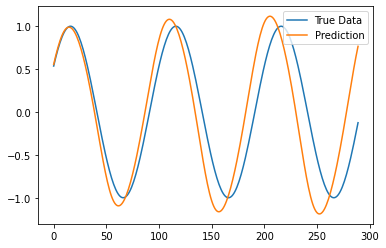

In [ ]:
train_test_model(forecast_model, feature_train, label_train, feature_test, label_test)

cos

model compiled
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 100, 50)           10400     
                                                                 
 dropout_44 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_29 (LSTM)              (None, 100)               60400     
                                                                 
 dropout_45 (Dropout)        (None, 100)               0         
                                                                 
 dense_41 (Dense)            (None, 1)                 101       
                                                                 
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
6/6 [=============

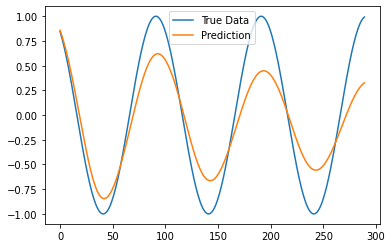

In [ ]:
train_test_model(forecast_model, feature_train_c, label_train_c, feature_test_c, label_test_c)

sin&cos

model compiled
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 100, 50)           10400     
                                                                 
 dropout_46 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_31 (LSTM)              (None, 100)               60400     
                                                                 
 dropout_47 (Dropout)        (None, 100)               0         
                                                                 
 dense_42 (Dense)            (None, 1)                 101       
                                                                 
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
6/6 [=============

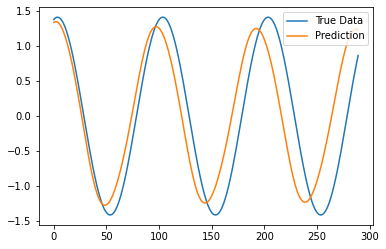

In [ ]:
train_test_model(forecast_model, feature_train_sc, label_train_sc, feature_test_sc, label_test_sc)

**Improved model**

**GRU50+LSTM100+Dropout - 10 epoch**

In [ ]:
# GRU model
def forecast_model_gru(feature_train):
  model = Sequential()
  model.add(GRU(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
  model.add(Dropout(0.2))
  model.add(LSTM(100, return_sequences=False))
  model.add(Dropout(0.2))
  # model.add(Dense(256, activation = "relu"))
  model.add(Dense(1, activation = "linear"))

  model.compile(loss='mse', optimizer='adam')
  print ('model compiled')
  print (model.summary())
  return model

model compiled
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 50)           7950      
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 68,451
Trainable params: 68,451
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
6/6 [================

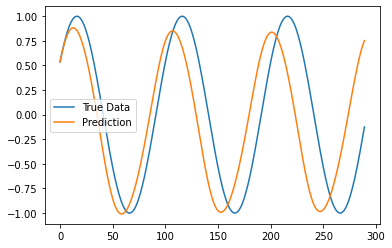

In [ ]:
train_test_model(forecast_model_gru, feature_train, label_train, feature_test, label_test)

model compiled
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 100, 50)           7950      
                                                                 
 dropout_2 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 68,451
Trainable params: 68,451
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
6/6 [==============

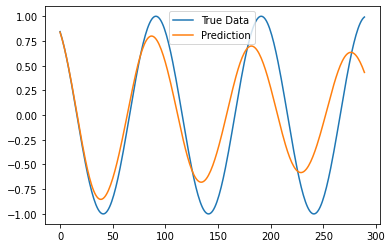

In [ ]:
train_test_model(forecast_model_gru, feature_train_c, label_train_c, feature_test_c, label_test_c)

model compiled
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 100, 50)           7950      
                                                                 
 dropout_4 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 68,451
Trainable params: 68,451
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
6/6 [==============

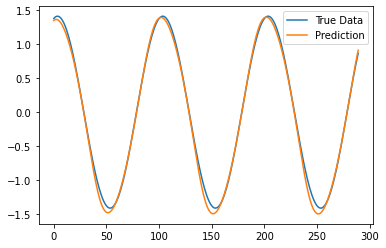

In [ ]:
train_test_model(forecast_model_gru, feature_train_sc, label_train_sc, feature_test_sc, label_test_sc)

**GRU50+LSTM100 - 10 epoch**

In [ ]:
# GRU model
def forecast_model_gru(feature_train):
  model = Sequential()
  model.add(GRU(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
  # model.add(Dropout(0.2))
  model.add(LSTM(100, return_sequences=False))
  # model.add(Dropout(0.2))
  # model.add(Dense(256, activation = "relu"))
  model.add(Dense(1, activation = "linear"))

  model.compile(loss='mse', optimizer='adam')
  print ('model compiled')
  print (model.summary())
  return model

sin

model compiled
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 100, 50)           7950      
                                                                 
 lstm_3 (LSTM)               (None, 100)               60400     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 68,451
Trainable params: 68,451
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
6/6 [==============================] - 10s 1s/step - loss: 0.4622 - val_loss: 0.1542
Epoch 2/10
6/6 [==============================] - 5s 846ms/step - loss: 0.1170 - val_loss: 0.0695
Epoch 3/10
6/6 [==============================] - 5s 836ms/step - loss: 0.0459 - val_loss: 0.0264
Ep

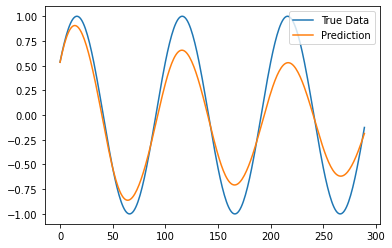

In [ ]:
train_test_model(forecast_model_gru, feature_train, label_train, feature_test, label_test)

cos

model compiled
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 100, 50)           7950      
                                                                 
 lstm_4 (LSTM)               (None, 100)               60400     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 68,451
Trainable params: 68,451
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
6/6 [==============================] - 10s 1s/step - loss: 0.2194 - val_loss: 0.1059
Epoch 2/10
6/6 [==============================] - 5s 844ms/step - loss: 0.0751 - val_loss: 0.0334
Epoch 3/10
6/6 [==============================] - 5s 840ms/step - loss: 0.0295 - val_loss: 0.0160
Ep

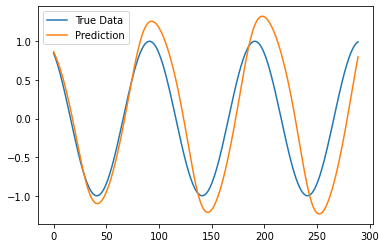

In [ ]:
train_test_model(forecast_model_gru, feature_train_c, label_train_c, feature_test_c, label_test_c)

sin&cos

model compiled
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 100, 50)           7950      
                                                                 
 lstm_5 (LSTM)               (None, 100)               60400     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 68,451
Trainable params: 68,451
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
6/6 [==============================] - 11s 1s/step - loss: 0.5495 - val_loss: 0.2123
Epoch 2/10
6/6 [==============================] - 5s 842ms/step - loss: 0.1759 - val_loss: 0.0817
Epoch 3/10
6/6 [==============================] - 5s 836ms/step - loss: 0.0633 - val_loss: 0.0372
Ep

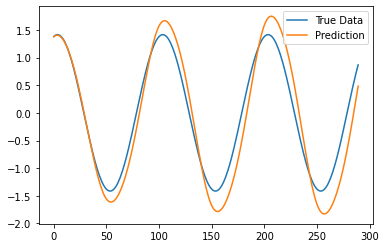

In [ ]:
train_test_model(forecast_model_gru, feature_train_sc, label_train_sc, feature_test_sc, label_test_sc)

**GRU100+LSTM50 - 20 epoch**

In [ ]:
def forecast_model_gru(feature_train):
  model = Sequential()
  model.add(GRU(100, return_sequences=True, input_shape=(feature_train.shape[1],1)))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dense(1, activation = "linear"))

  model.compile(loss='mse', optimizer='adam')
  print ('model compiled')
  print (model.summary())
  return model

sin

model compiled
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_13 (GRU)                (None, 100, 100)          30900     
                                                                 
 lstm_13 (LSTM)              (None, 50)                30200     
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 61,151
Trainable params: 61,151
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
6/6 [==============================] - 10s 980ms/step - loss: 0.3131 - val_loss: 0.0909
Epoch 2/20
6/6 [==============================] - 5s 790ms/step - loss: 0.0914 - val_loss: 0.0709
Epoch 3/20
6/6 [==============================] - 5s 820ms/step - loss: 0.0500 - val_loss: 0.031

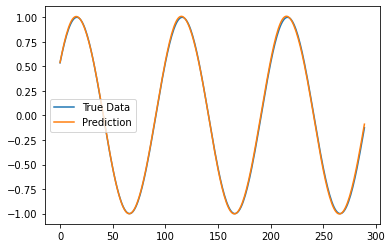

In [ ]:
train_test_model(forecast_model_gru, feature_train, label_train, feature_test, label_test)

cos

model compiled
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_14 (GRU)                (None, 100, 100)          30900     
                                                                 
 lstm_14 (LSTM)              (None, 50)                30200     
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 61,151
Trainable params: 61,151
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
6/6 [==============================] - 14s 1s/step - loss: 0.3812 - val_loss: 0.1420
Epoch 2/20
6/6 [==============================] - 8s 1s/step - loss: 0.1034 - val_loss: 0.0986
Epoch 3/20
6/6 [==============================] - 6s 1s/step - loss: 0.0684 - val_loss: 0.0393
Epoch 4

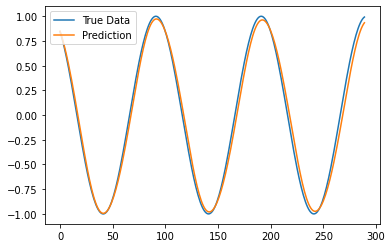

In [ ]:
train_test_model(forecast_model_gru, feature_train_c, label_train_c, feature_test_c, label_test_c)

sin&cos

model compiled
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_15 (GRU)                (None, 100, 100)          30900     
                                                                 
 lstm_15 (LSTM)              (None, 50)                30200     
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 61,151
Trainable params: 61,151
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
6/6 [==============================] - 10s 1s/step - loss: 0.9046 - val_loss: 0.3039
Epoch 2/20
6/6 [==============================] - 5s 805ms/step - loss: 0.2176 - val_loss: 0.1868
Epoch 3/20
6/6 [==============================] - 5s 808ms/step - loss: 0.1518 - val_loss: 0.0770
E

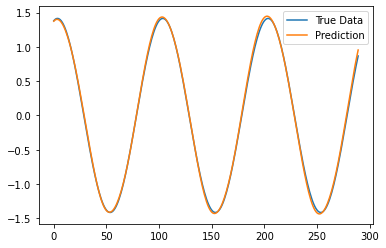

In [ ]:
train_test_model(forecast_model_gru, feature_train_sc, label_train_sc, feature_test_sc, label_test_sc)

# Case 2. NY Stock Price Prediction RNN LSTM GRU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip -u "/content/drive/MyDrive/AIS/DL/2022-23/practice/Lab6/prices-split-adjusted.csv.zip" -d "/content/drive/MyDrive/Colab Notebooks/Lab6/prices-split-adjusted.csv"

Archive:  /content/drive/MyDrive/AIS/DL/2022-23/practice/Lab6/prices-split-adjusted.csv.zip
  inflating: /content/drive/MyDrive/Colab Notebooks/Lab6/prices-split-adjusted.csv/prices-split-adjusted.csv  


In [ ]:
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10
test_set_size_percentage = 10

In [ ]:
# import all stock prices
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Lab6/prices-split-adjusted.csv/prices-split-adjusted.csv", index_col = 0)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [ ]:
# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])


number of different stocks:  501
['BBBY', 'IFF', 'PX', 'JCI', 'WY', 'PFE', 'ABT', 'SJM', 'AVB', 'FFIV']


In [ ]:
df.tail()

,symbol,open,close,low,high,volume
date,,,,,,
2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0
2016-12-30,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


In [ ]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [ ]:
df["symbol"].value_counts()

KSU     1762
NOC     1762
ORCL    1762
OMC     1762
OKE     1762
        ... 
KHC      378
HPE      304
CSRA     284
WLTW     251
FTV      126
Name: symbol, Length: 501, dtype: int64

In [ ]:
df["symbol"].value_counts().unique()

array([1762, 1761, 1683, 1540, 1008,  987,  896,  894,  892,  853,  786,
        504,  385,  378,  304,  284,  251,  126])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


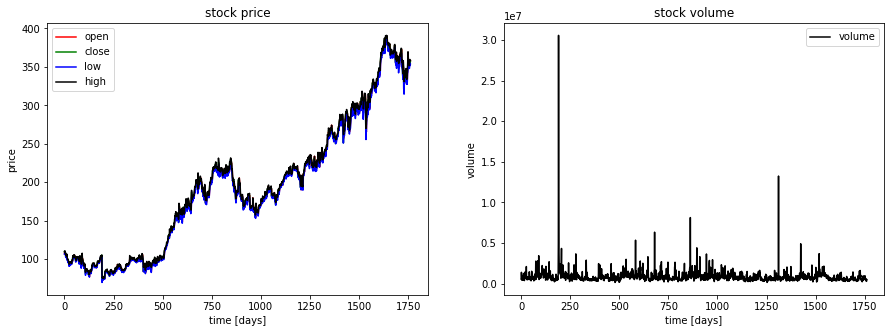

In [ ]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'EQIX'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'EQIX'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'EQIX'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()
plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

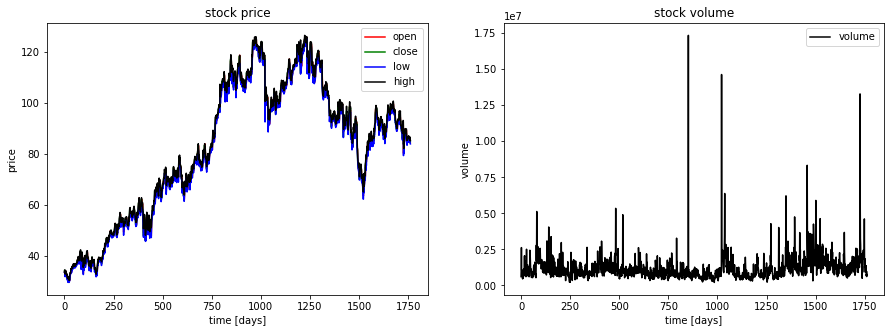

In [ ]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'KSU'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'KSU'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'KSU'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'KSU'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()
plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'KSU'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [ ]:
# function for min-max normalization of stock
def normalize_data(df):
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
  df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
  df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
  df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
  return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
  data_raw = stock.to_numpy() # convert to numpy array
  data = []
  # create all possible sequences of length seq_len
  for index in range(len(data_raw) - seq_len):
    data.append(data_raw[index: index + seq_len])

  data = np.array(data);
  valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));
  test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
  train_set_size = data.shape[0] - (valid_set_size + test_set_size);
  x_train = data[:train_set_size,:-1,:]
  y_train = data[:train_set_size,-1,:]
  x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
  y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
  x_test = data[train_set_size+valid_set_size:,:-1,:]
  y_test = data[train_set_size+valid_set_size:,-1,:]
  return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [ ]:
# KSU
company_stock = df[df['symbol'] == 'KSU']
company_stock.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,KSU,33.490002,33.650002,33.419998,33.869999,613500.0
2010-01-05,KSU,33.639999,34.310001,33.500000,34.439999,1129300.0
2010-01-06,KSU,33.240002,32.049999,31.870001,33.590000,2627400.0
2010-01-07,KSU,32.040001,32.410000,31.799999,32.799999,1076500.0
2010-01-08,KSU,32.290001,33.860001,32.290001,34.020000,1005000.0


In [ ]:
# choose one stock
df_stock = df[df.symbol == 'KSU'].copy()
df_stock.drop(['symbol'], axis=1, inplace=True)

df_stock.drop(['volume'], axis=1,inplace=True)

cols = list(df_stock.columns.values)

print('df_stock.columns.values = ', cols)

df_stock.columns.values =  ['open', 'close', 'low', 'high']


In [ ]:
# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

In [ ]:
# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_valid.shape =', x_valid.shape)
print('y_valid.shape =', y_valid.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

x_train.shape = (1394, 19, 4)
y_train.shape = (1394, 4)
x_valid.shape = (174, 19, 4)
y_valid.shape = (174, 4)
x_test.shape = (174, 19, 4)
y_test.shape = (174, 4)


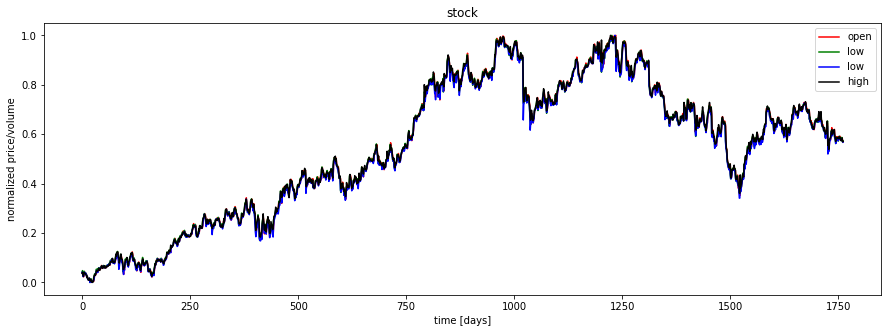

In [ ]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')

#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [ ]:
def show_results(y_train, y_valid, y_test, y_train_pred, y_valid_pred, y_test_pred, ft=0):
  # 0 = open, 1 = close, 2 = highest, 3 = lowest

  # show predictions
  plt.figure(figsize=(15, 5));
  plt.subplot(1,2,1);

  plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

  plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
          color='gray', label='valid target')

  plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                    y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
          y_test[:,ft], color='black', label='test target')

  plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
          label='train prediction')

  plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
          y_valid_pred[:,ft], color='orange', label='valid prediction')

  plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                    y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
          y_test_pred[:,ft], color='green', label='test prediction')

  plt.title('past and future stock prices')
  plt.xlabel('time [days]')
  plt.ylabel('normalized price')
  plt.legend(loc='best');

  plt.subplot(1,2,2);

  plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
          y_test[:,ft], color='black', label='test target')

  plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
          y_test_pred[:,ft], color='green', label='test prediction')

  plt.title('future stock prices')
  plt.xlabel('time [days]')
  plt.ylabel('normalized price')
  plt.legend(loc='best');

**GRU100 + LSTM50 + Dropout(0.2)**

In [ ]:
# LSTM model
def forecast_model_stock(x_train):
  model = Sequential()
  model.add(GRU(100, return_sequences=True, input_shape=(x_train.shape[-2],x_train.shape[-1])))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation = "linear"))

  model.compile(loss='mse', optimizer='adam')
  print ('model compiled')
  print (model.summary())
  return model

model compiled
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_27 (GRU)                (None, 19, 100)           31800     
                                                                 
 dropout_66 (Dropout)        (None, 19, 100)           0         
                                                                 
 lstm_41 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_67 (Dropout)        (None, 50)                0         
                                                                 
 dense_34 (Dense)            (None, 1)                 51        
                                                                 
Total params: 62,051
Trainable params: 62,051
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
22/22 [===========

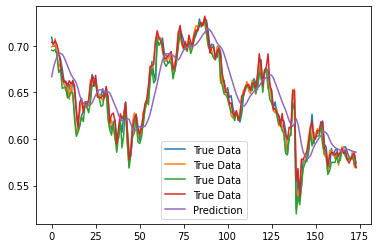

In [ ]:
model2 = forecast_model_stock(x_train)
model2.fit(x_train, y_train, batch_size=64, epochs=10, validation_data = (x_valid, y_valid))

predictions = model2.predict(x_test)
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True Data')
plt.plot(predictions, label='Prediction')
plt.legend()
plt.show()

In [ ]:
y_train_pred = model2.predict(x_train)
y_valid_pred = model2.predict(x_valid)
y_test_pred = model2.predict(x_test)

6/6 [==============================] - 0s 5ms/step


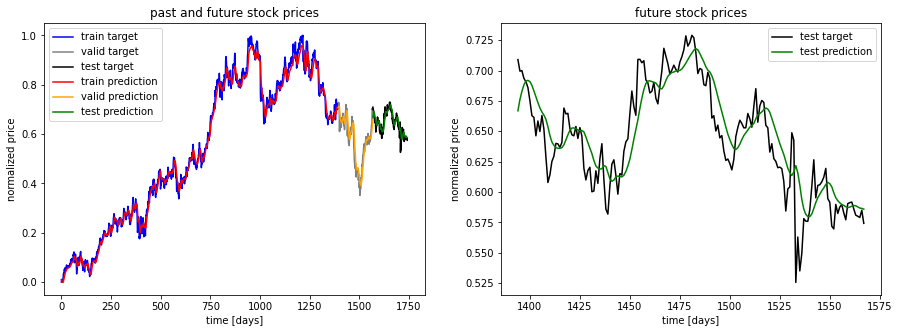

In [ ]:
show_results(y_train, y_valid, y_test, y_train_pred, y_valid_pred, y_test_pred)

model compiled
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_25 (GRU)                (None, 19, 100)           31800     
                                                                 
 dropout_60 (Dropout)        (None, 19, 100)           0         
                                                                 
 lstm_37 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_61 (Dropout)        (None, 50)                0         
                                                                 
 dense_31 (Dense)            (None, 1)                 51        
                                                                 
Total params: 62,051
Trainable params: 62,051
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
140/140 [=========

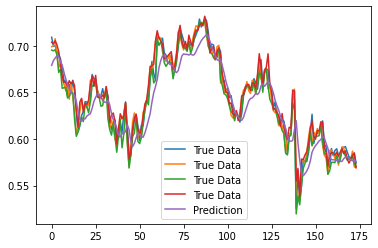

In [ ]:
model3 = forecast_model_stock(x_train)
model3.fit(x_train, y_train, batch_size=10, epochs=10, validation_data = (x_valid, y_valid))

predictions = model3.predict(x_test)
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True Data')
plt.plot(predictions, label='Prediction')
plt.legend()
plt.show()

In [ ]:
y_train_pred = model3.predict(x_train)
y_valid_pred = model3.predict(x_valid)
y_test_pred = model3.predict(x_test)

6/6 [==============================] - 0s 3ms/step


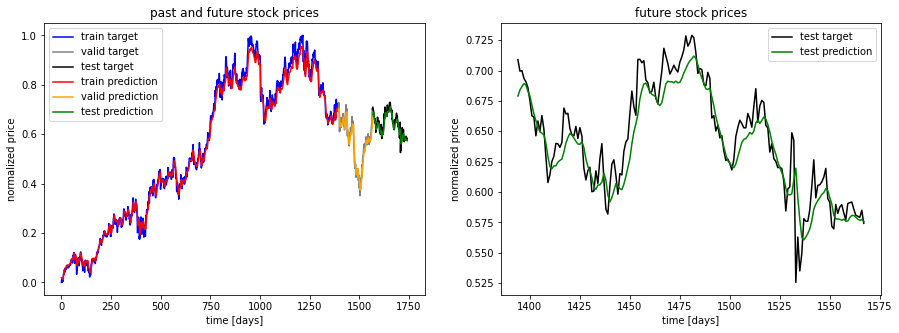

In [ ]:
show_results(y_train, y_valid, y_test, y_train_pred, y_valid_pred, y_test_pred)

**GRU100 + LSTM50 + Dropout(0.2) - 100 epoch**

model compiled
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 19, 100)           31800     
                                                                 
 dropout_26 (Dropout)        (None, 19, 100)           0         
                                                                 
 lstm_20 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_27 (Dropout)        (None, 50)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 62,051
Trainable params: 62,051
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
28/28 [==========

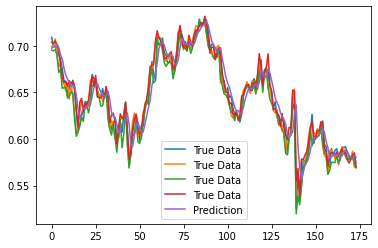

In [ ]:
model2 = forecast_model_stock(x_train)
model2.fit(x_train, y_train, batch_size=50, epochs=100, validation_data = (x_valid, y_valid))

predictions = model2.predict(x_test)
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True Data')
plt.plot(predictions, label='Prediction')
plt.legend()
plt.show()

In [ ]:
y_train_pred = model2.predict(x_train)
y_valid_pred = model2.predict(x_valid)
y_test_pred = model2.predict(x_test)

6/6 [==============================] - 0s 3ms/step


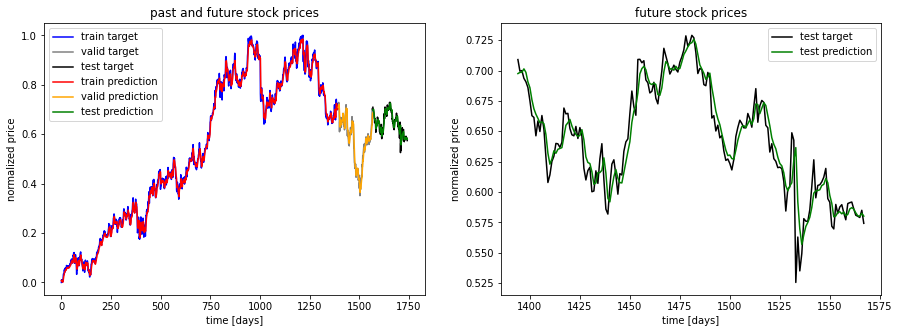

In [ ]:
show_results(y_train, y_valid, y_test, y_train_pred, y_valid_pred, y_test_pred)

**LSTM + Bidirectional + Dropout**

In [ ]:
# LSTM model
def forecast_model_stock2(x_train):
  model = Sequential()
  model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[-2],x_train.shape[-1])))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(50, return_sequences=False)))
  model.add(Dropout(0.2))
  # model.add(Dense(32, activation = "relu"))
  model.add(Dense(1, activation = "linear"))

  model.compile(loss='mse', optimizer='adam')
  print ('model compiled')
  print (model.summary())
  return model

model compiled
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 19, 100)           42000     
                                                                 
 dropout_62 (Dropout)        (None, 19, 100)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 100)              60400     
 l)                                                              
                                                                 
 dropout_63 (Dropout)        (None, 100)               0         
                                                                 
 dense_32 (Dense)            (None, 1)                 101       
                                                                 
Total params: 102,501
Trainable params: 102,501
Non-trainable params: 0
________________________________

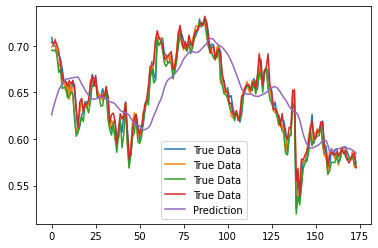

In [ ]:
model2 = forecast_model_stock2(x_train)
model2.fit(x_train, y_train, batch_size=50, epochs=10, validation_data = (x_valid, y_valid))

predictions = model2.predict(x_test)
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True Data')
plt.plot(predictions, label='Prediction')
plt.legend()
plt.show()

In [ ]:
y_train_pred = model2.predict(x_train)
y_valid_pred = model2.predict(x_valid)
y_test_pred = model2.predict(x_test)

6/6 [==============================] - 0s 5ms/step


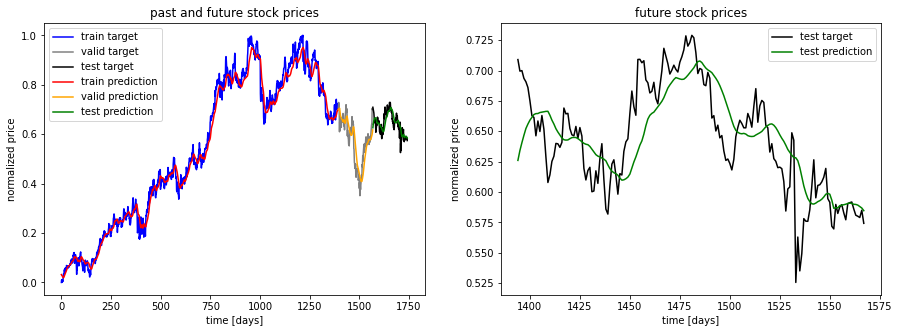

In [ ]:
show_results(y_train, y_valid, y_test, y_train_pred, y_valid_pred, y_test_pred)

**GRU + Dropout - batchsize=10**

In [ ]:
def forecast_model_stock3(x_train):
  model = Sequential()
  model.add(GRU(100, return_sequences=False, input_shape=(x_train.shape[-2],x_train.shape[-1])))
  model.add(Dropout(0.2))
  #model.add(LSTM(50, return_sequences=False))
  # model.add(Bidirectional(LSTM(50, return_sequences=False))) 
  # model.add(Dense(32, activation = "relu"))
  model.add(Dense(1, activation = "linear"))

  model.compile(loss='mse', optimizer='adam')
  print ('model compiled')
  print (model.summary())
  return model

model compiled
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_34 (GRU)                (None, 100)               31800     
                                                                 
 dropout_73 (Dropout)        (None, 100)               0         
                                                                 
 dense_40 (Dense)            (None, 1)                 101       
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
140/140 [==============================] - 3s 7ms/step - loss: 0.0179 - val_loss: 0.0012
Epoch 2/10
140/140 [==============================] - 1s 5ms/step - loss: 0.0030 - val_loss: 7.4981e-04
Epoch 3/10
140/140 [==============================] - 1s 5ms/step - loss: 0.0025 - val_lo

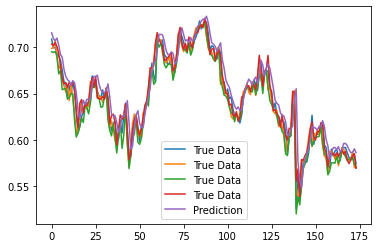

In [ ]:
model3 = forecast_model_stock3(x_train)
model3.fit(x_train, y_train, batch_size=10, epochs=10, validation_data = (x_valid, y_valid))

predictions = model3.predict(x_test)
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True Data')
plt.plot(predictions, label='Prediction')
plt.legend()
plt.show()

In [ ]:
y_train_pred = model3.predict(x_train)
y_valid_pred = model3.predict(x_valid)
y_test_pred = model3.predict(x_test)

6/6 [==============================] - 0s 3ms/step


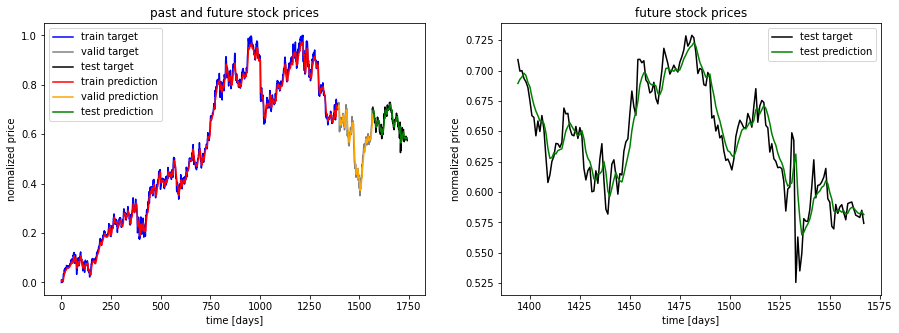

In [ ]:
show_results(y_train, y_valid, y_test, y_train_pred, y_valid_pred, y_test_pred)

**LSTM + reccurent dropout**

In [ ]:
def forecast_model_stock4(x_train):
  model = Sequential()
  model.add(LSTM(100, return_sequences=False, input_shape=(x_train.shape[-2],x_train.shape[-1]), recurrent_dropout=0.2))
  # model.add(Dropout(0.2))
  #model.add(LSTM(50, return_sequences=False))
  # model.add(Bidirectional(LSTM(50, return_sequences=False))) 
  # model.add(Dense(32, activation = "relu"))
  model.add(Dense(1, activation = "linear"))

  model.compile(loss='mse', optimizer='adam')
  print ('model compiled')
  print (model.summary())
  return model

model compiled
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 100)               42000     
                                                                 
 dense_41 (Dense)            (None, 1)                 101       
                                                                 
Total params: 42,101
Trainable params: 42,101
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
140/140 [==============================] - 14s 82ms/step - loss: 0.0109 - val_loss: 0.0015
Epoch 2/10
140/140 [==============================] - 9s 66ms/step - loss: 8.6594e-04 - val_loss: 0.0013
Epoch 3/10
140/140 [==============================] - 9s 65ms/step - loss: 8.1565e-04 - val_loss: 0.0013
Epoch 4/10
140/140 [==============================] - 10s 68ms/step - loss: 7.1572e-04 - val_loss: 0.0012
Epoch 5

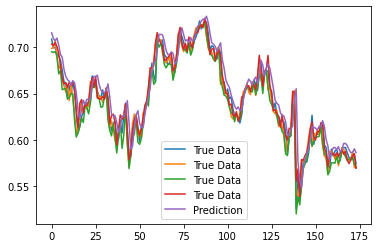

In [ ]:
model4 = forecast_model_stock4(x_train)
model4.fit(x_train, y_train, batch_size=10, epochs=10, validation_data = (x_valid, y_valid))

predictions = model3.predict(x_test)
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True Data')
plt.plot(predictions, label='Prediction')
plt.legend()
plt.show()

In [ ]:
y_train_pred = model4.predict(x_train)
y_valid_pred = model4.predict(x_valid)
y_test_pred = model4.predict(x_test)

6/6 [==============================] - 0s 2ms/step


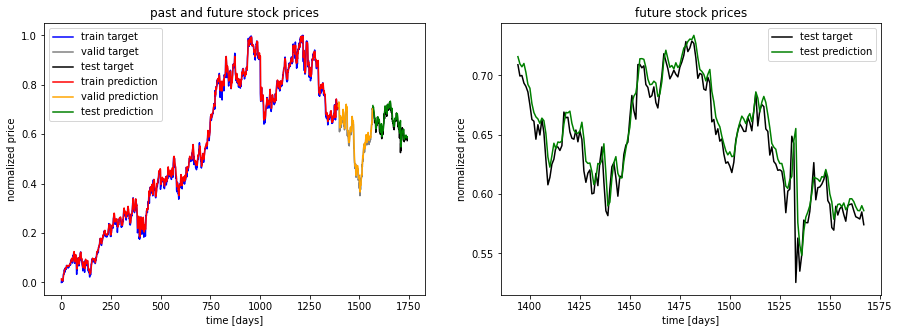

In [ ]:
show_results(y_train, y_valid, y_test, y_train_pred, y_valid_pred, y_test_pred)